# Evaluation Metric Testing

The point of this notebook is to walk through an evaluation metric taken from one of the kernels posted on [Kaggle](https://www.kaggle.com/wcukierski/example-metric-implementation) to ensure that was it was functioning correctly and gain a deeper undertanding of the [IoU](https://www.kaggle.com/c/data-science-bowl-2018#evaluation) metric.

In [1]:
!pwd

/home/williamgrimes/nuclei_segmentation/notebooks


In [2]:
import skimage
import importlib
import numpy as np

from scipy import stats
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline

In [3]:
from utils import imaging
from utils import evaluate

In [4]:
importlib.reload(imaging)
importlib.reload(evaluate)

<module 'utils.evaluate' from '/home/williamgrimes/nuclei_segmentation/utils/evaluate.py'>

# Notes on method below 
When we are calculating the the intersection of objects between images we use a 2D histogram of the two images. This takes the two images flattened and compares the pixel values at each location. It reutrns an $\mathbf{n}$ $\times$ $\mathbf{m}$ matrix where $\mathbf{n}$ is the number of true objects and $\mathbf{m}$ is the number of predicted objects. The values of this matrix are counts of the paired pixel values between the two images. So if row 1, column 2 = 50, this means a pixel value of 1 in the true image was given a value of 2 in the predicted image.

$\textbf{Note:}$ It doesn't matter if the pixel value of the predicted mask is different than the ground truth mask (unless it is 0). All we care about is that a predict object has pixels that overlaps with a ground truth object.

## Evaluate a single image

Evaluate a single image to check the result of our evaluation metric is reasonable.

In [5]:
image_id = '0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9'
gt_path = imaging.get_path('output_train_1_lab_gt')
seg_path = imaging.get_path('output_train_1_lab_seg')

gt_image_1 = skimage.io.imread(gt_path + image_id + '.png' )
seg_image_1 = skimage.io.imread(seg_path + image_id + '.png' )

Text(0.5,1,'Segmented')

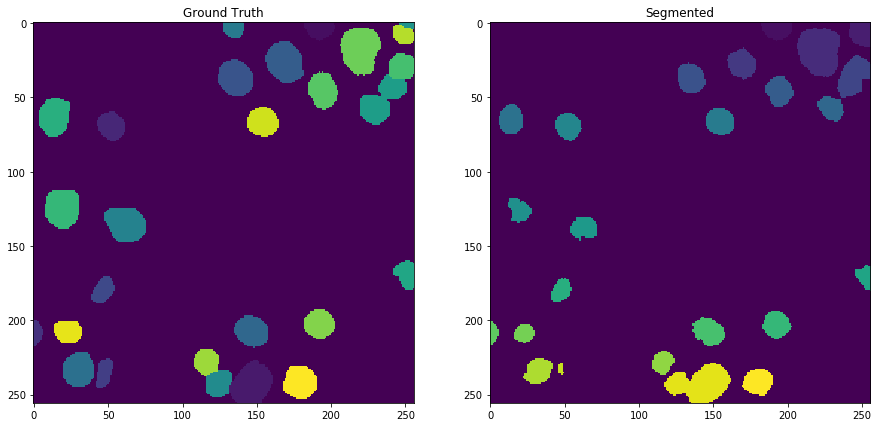

In [7]:
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(gt_image_1)
axarr[0].set_title('Ground Truth')
axarr[1].imshow(seg_image_1)
axarr[1].set_title('Segmented')


# Evaluate test cases

We examine how the evaluation metric peforms in a few scenarios.

1. Perfect overlap with nonmatching class labels.
2. Not predicting one the ground truth objects (False Negative)
3. How a 50% overlap performs with a threshold of .5
4. Two predicted objects that lay over the ground truth object.

In [8]:
n = 1000 # matrices will be nxn                                                                                                                             
gt = np.zeros((n,n))
gt[300:700,300:700] = 1
gt[800:850,800:850] = 2


t1 = np.zeros((n,n))
t2 = np.zeros((n,n))
t3 = np.zeros((n,n))
t4 = np.zeros((n,n))                                                                                                                                                 

# perfect prediction
t1[300:700,300:700] = 2
t1[800:850,800:850] = 1


# different labels                                                                                                                                          
t2[300:700,300:700] = 20                                                                                         

# 50% overlap
t3[300:700,500:900] = 1

# Having to small sub regions where the 1 truth region is.
t4[300:500,300:700] = 1 # creating first small sub region
t4[500:700,300:700] = 2 # creating second small sub region
test_cases = [t1,t2,t3,t4]

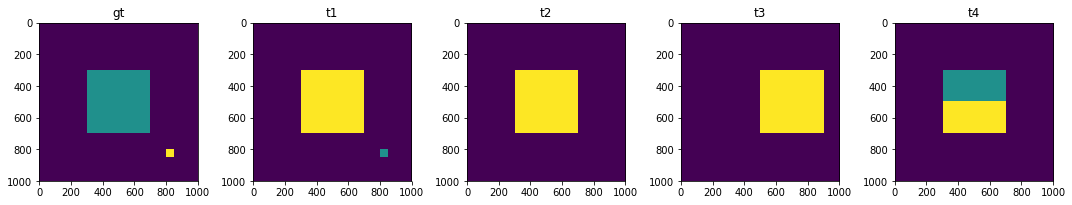

In [64]:
f, axarr = plt.subplots(1,5,figsize=(15,15))
axarr[0].imshow(gt)
axarr[0].set_title('gt')
axarr[1].imshow(t1)
axarr[1].set_title('t1')
axarr[2].imshow(t2)
axarr[2].set_title('t2')
axarr[3].imshow(t3)
axarr[3].set_title('t3')
axarr[4].imshow(t4)
axarr[4].set_title('t4')
f.tight_layout()

## Test case 1

In [10]:
evaluate.evaluate_image(gt, t1)

# true nuclei: 2
# predicted pred: 2

thresh	tp	fp	fn	p
0.500	2	0	0	1.000
0.550	2	0	0	1.000
0.600	2	0	0	1.000
0.650	2	0	0	1.000
0.700	2	0	0	1.000
0.750	2	0	0	1.000
0.800	2	0	0	1.000
0.850	2	0	0	1.000
0.900	2	0	0	1.000
0.950	2	0	0	1.000


1.0

As we would hope, inverting the labels has no effect on the evaluation.

## Test case 2

In [11]:
evaluate.evaluate_image(gt, t2)

# true nuclei: 2
# predicted pred: 1

thresh	tp	fp	fn	p
0.500	1	0	1	0.500
0.550	1	0	1	0.500
0.600	1	0	1	0.500
0.650	1	0	1	0.500
0.700	1	0	1	0.500
0.750	1	0	1	0.500
0.800	1	0	1	0.500
0.850	1	0	1	0.500
0.900	1	0	1	0.500
0.950	1	0	1	0.500


0.5

Since there is one correctly predicted object and 1 missed sobject, so 1 TP and 1 FN, the average precision is .5 as expected.

## Test case 3

In [12]:
evaluate.evaluate_image(gt, t3)

# true nuclei: 2
# predicted pred: 1

thresh	tp	fp	fn	p
0.500	0	1	2	0.000
0.550	0	1	2	0.000
0.600	0	1	2	0.000
0.650	0	1	2	0.000
0.700	0	1	2	0.000
0.750	0	1	2	0.000
0.800	0	1	2	0.000
0.850	0	1	2	0.000
0.900	0	1	2	0.000
0.950	0	1	2	0.000


0.0

The object has a 50$\%$ overlap with the ground truth object so the IoU is .3, which gives 0 TPs for all thresholds used.

## Test case 4

In [13]:
evaluate.evaluate_image(gt, t4)

# true nuclei: 2
# predicted pred: 2

thresh	tp	fp	fn	p
0.500	0	2	2	0.000
0.550	0	2	2	0.000
0.600	0	2	2	0.000
0.650	0	2	2	0.000
0.700	0	2	2	0.000
0.750	0	2	2	0.000
0.800	0	2	2	0.000
0.850	0	2	2	0.000
0.900	0	2	2	0.000
0.950	0	2	2	0.000


0.0

Neither predicted object has an IoU with the ground truth object that satisifies any of the thresholds so there are 0 TPs for each threshold.

## Evaluate all images

Evaluate all images in stage 1 to test the `evaluate_images` function and see the distribution of scores.


In [15]:
scores = evaluate.evaluate_images(stage_num=1)

# true nuclei: 27
# predicted pred: 19

thresh	tp	fp	fn	p
0.500	14	5	13	0.438
0.550	14	5	13	0.438
0.600	13	6	14	0.394
0.650	12	7	15	0.353
0.700	8	11	19	0.211
0.750	4	15	23	0.095
0.800	3	16	24	0.070
0.850	2	17	25	0.045
0.900	1	18	26	0.022
0.950	0	19	27	0.000
image: 0 of 670
00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552
score is 0.206508919097

# true nuclei: 36
# predicted pred: 34

thresh	tp	fp	fn	p
0.500	34	0	2	0.944
0.550	33	1	3	0.892
0.600	32	2	4	0.842
0.650	32	2	4	0.842
0.700	32	2	4	0.842
0.750	32	2	4	0.842
0.800	31	3	5	0.795
0.850	28	6	8	0.667
0.900	23	11	13	0.489
0.950	9	25	27	0.148
image: 1 of 670
003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1
score is 0.730319853624

# true nuclei: 70
# predicted pred: 44

thresh	tp	fp	fn	p
0.500	18	26	52	0.188
0.550	17	27	53	0.175
0.600	15	29	55	0.152
0.650	15	29	55	0.152
0.700	14	30	56	0.140
0.750	12	32	58	0.118
0.800	11	33	59	0.107
0.850	9	35	61	0.086
0.900	5	39	65	0.046
0.950	0	44	70	0.000
image: 2 of 67

0.500	7	0	0	1.000
0.550	7	0	0	1.000
0.600	7	0	0	1.000
0.650	7	0	0	1.000
0.700	7	0	0	1.000
0.750	7	0	0	1.000
0.800	7	0	0	1.000
0.850	6	1	1	0.750
0.900	4	3	3	0.400
0.950	3	4	4	0.273
image: 24 of 670
08ae2741df2f5ac815c0f272a8c532b5167ee853be9b939b9b8b7fa93560868a
score is 0.842272727273

# true nuclei: 44
# predicted pred: 1102

thresh	tp	fp	fn	p
0.500	3	1099	41	0.003
0.550	3	1099	41	0.003
0.600	3	1099	41	0.003
0.650	3	1099	41	0.003
0.700	3	1099	41	0.003
0.750	3	1099	41	0.003
0.800	2	1100	42	0.002
0.850	2	1100	42	0.002
0.900	2	1100	42	0.002
0.950	0	1102	44	0.000
image: 25 of 670
091944f1d2611c916b98c020bd066667e33f4639159b2a92407fe5a40788856d
score is 0.00209927867408

# true nuclei: 65
# predicted pred: 48

thresh	tp	fp	fn	p
0.500	40	8	25	0.548
0.550	40	8	25	0.548
0.600	37	11	28	0.487
0.650	37	11	28	0.487
0.700	36	12	29	0.468
0.750	32	16	33	0.395
0.800	28	20	37	0.329
0.850	18	30	47	0.189
0.900	7	41	58	0.066
0.950	2	46	63	0.018
image: 26 of 670
094afe36759e7daffe12188ab5987581d405b06720f

# true nuclei: 34
# predicted pred: 31

thresh	tp	fp	fn	p
0.500	23	8	11	0.548
0.550	21	10	13	0.477
0.600	21	10	13	0.477
0.650	17	14	17	0.354
0.700	11	20	23	0.204
0.750	10	21	24	0.182
0.800	8	23	26	0.140
0.850	2	29	32	0.032
0.900	0	31	34	0.000
0.950	0	31	34	0.000
image: 49 of 670
136000dc18fa6def2d6c98d4d0b2084d13c22eaffe82e26c665bcaa2a9e51261
score is 0.241394996329

# true nuclei: 10
# predicted pred: 10

thresh	tp	fp	fn	p
0.500	9	1	1	0.818
0.550	9	1	1	0.818
0.600	9	1	1	0.818
0.650	9	1	1	0.818
0.700	9	1	1	0.818
0.750	8	2	2	0.667
0.800	8	2	2	0.667
0.850	6	4	4	0.429
0.900	6	4	4	0.429
0.950	2	8	8	0.111
image: 50 of 670
139946af9e2c7ef4f0298e622b831dbef5e5c0cd088eb5bc3382f8df9355443d
score is 0.63924963925

# true nuclei: 17
# predicted pred: 15

thresh	tp	fp	fn	p
0.500	15	0	2	0.882
0.550	11	4	6	0.524
0.600	10	5	7	0.455
0.650	9	6	8	0.391
0.700	7	8	10	0.280
0.750	6	9	11	0.231
0.800	5	10	12	0.185
0.850	2	13	15	0.067
0.900	2	13	15	0.067
0.950	1	14	16	0.032
image: 51 of 670
13c8ff1f49886e91c9


thresh	tp	fp	fn	p
0.500	19	1	4	0.792
0.550	19	1	4	0.792
0.600	18	2	5	0.720
0.650	17	3	6	0.654
0.700	16	4	7	0.593
0.750	16	4	7	0.593
0.800	16	4	7	0.593
0.850	15	5	8	0.536
0.900	14	6	9	0.483
0.950	9	11	14	0.265
image: 72 of 670
1bd0f2b3000b7c7723f25335fabfcdddcdf4595dd7de1b142d52bb7a186885f0
score is 0.601813605371

# true nuclei: 12
# predicted pred: 10

thresh	tp	fp	fn	p
0.500	10	0	2	0.833
0.550	9	1	3	0.692
0.600	9	1	3	0.692
0.650	9	1	3	0.692
0.700	9	1	3	0.692
0.750	8	2	4	0.571
0.800	7	3	5	0.467
0.850	7	3	5	0.467
0.900	4	6	8	0.222
0.950	0	10	12	0.000
image: 73 of 670
1c2f9e121fc207efff79d46390df1a740566b683ff56a96d8cabe830a398dd2e
score is 0.532954822955

# true nuclei: 66
# predicted pred: 44

thresh	tp	fp	fn	p
0.500	28	16	38	0.341
0.550	25	19	41	0.294
0.600	23	21	43	0.264
0.650	20	24	46	0.222
0.700	18	26	48	0.196
0.750	13	31	53	0.134
0.800	11	33	55	0.111
0.850	10	34	56	0.100
0.900	5	39	61	0.048
0.950	3	41	63	0.028
image: 74 of 670
1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c829


thresh	tp	fp	fn	p
0.500	3	12	12	0.111
0.550	3	12	12	0.111
0.600	3	12	12	0.111
0.650	2	13	13	0.071
0.700	2	13	13	0.071
0.750	2	13	13	0.071
0.800	2	13	13	0.071
0.850	2	13	13	0.071
0.900	0	15	15	0.000
0.950	0	15	15	0.000
image: 97 of 670
2255d5aba044256bb92f6b7cbed0fca46d972c7b6b1a59dcbe7f682c5777d074
score is 0.0690476190476

# true nuclei: 9
# predicted pred: 8

thresh	tp	fp	fn	p
0.500	8	0	1	0.889
0.550	8	0	1	0.889
0.600	8	0	1	0.889
0.650	8	0	1	0.889
0.700	8	0	1	0.889
0.750	8	0	1	0.889
0.800	8	0	1	0.889
0.850	6	2	3	0.545
0.900	5	3	4	0.417
0.950	4	4	5	0.308
image: 98 of 670
2349e95ece2857c89db7e4a8be8c88af0b45f3c4262608120cb3bd6ef51fd241
score is 0.749203574204

# true nuclei: 8
# predicted pred: 8

thresh	tp	fp	fn	p
0.500	8	0	0	1.000
0.550	8	0	0	1.000
0.600	8	0	0	1.000
0.650	8	0	0	1.000
0.700	8	0	0	1.000
0.750	8	0	0	1.000
0.800	8	0	0	1.000
0.850	8	0	0	1.000
0.900	5	3	3	0.455
0.950	4	4	4	0.333
image: 99 of 670
237802ac5005f9cf782367156c46c383efd9e05088e5768ca883cbbe24abadb1
score is 0.8


thresh	tp	fp	fn	p
0.500	7	0	0	1.000
0.550	7	0	0	1.000
0.600	7	0	0	1.000
0.650	7	0	0	1.000
0.700	7	0	0	1.000
0.750	7	0	0	1.000
0.800	7	0	0	1.000
0.850	7	0	0	1.000
0.900	7	0	0	1.000
0.950	5	2	2	0.556
image: 124 of 670
2d53d7ec0c579fffd6710c956288537d46c719a93c6a04ac0d6550f75a6a6493
score is 0.955555555556

# true nuclei: 117
# predicted pred: 53

thresh	tp	fp	fn	p
0.500	19	34	98	0.126
0.550	15	38	102	0.097
0.600	15	38	102	0.097
0.650	15	38	102	0.097
0.700	13	40	104	0.083
0.750	7	46	110	0.043
0.800	4	49	113	0.024
0.850	1	52	116	0.006
0.900	1	52	116	0.006
0.950	0	53	117	0.000
image: 125 of 670
2dd3356f2dcf470aec4003800744dfec6490e75d88011e1d835f4f3d60f88e7a
score is 0.057782843333

# true nuclei: 16
# predicted pred: 12

thresh	tp	fp	fn	p
0.500	9	3	7	0.474
0.550	9	3	7	0.474
0.600	9	3	7	0.474
0.650	9	3	7	0.474
0.700	8	4	8	0.400
0.750	8	4	8	0.400
0.800	7	5	9	0.333
0.850	7	5	9	0.333
0.900	4	8	12	0.167
0.950	1	11	15	0.037
image: 126 of 670
2dd9d8c797fc695665326fc8fd0eb5cd292139fa478ccb5acb7fb


thresh	tp	fp	fn	p
0.500	15	11	29	0.273
0.550	13	13	31	0.228
0.600	12	14	32	0.207
0.650	11	15	33	0.186
0.700	9	17	35	0.148
0.750	4	22	40	0.061
0.800	3	23	41	0.045
0.850	1	25	43	0.014
0.900	0	26	44	0.000
0.950	0	26	44	0.000
image: 148 of 670
3582166ee20755856adf4882a8bfacb616fce4247911605a109c4862de421bcd
score is 0.116155059509

# true nuclei: 52
# predicted pred: 32

thresh	tp	fp	fn	p
0.500	25	7	27	0.424
0.550	22	10	30	0.355
0.600	21	11	31	0.333
0.650	18	14	34	0.273
0.700	15	17	37	0.217
0.750	13	19	39	0.183
0.800	11	21	41	0.151
0.850	8	24	44	0.105
0.900	7	25	45	0.091
0.950	3	29	49	0.037
image: 149 of 670
358e47eaa1e9222252793fe0fb8c77028d4e0d4360b95a07c9fe6df6a2066556
score is 0.216901224254

# true nuclei: 55
# predicted pred: 1255

thresh	tp	fp	fn	p
0.500	8	1247	47	0.006
0.550	7	1248	48	0.005
0.600	6	1249	49	0.005
0.650	5	1250	50	0.004
0.700	5	1250	50	0.004
0.750	5	1250	50	0.004
0.800	3	1252	52	0.002
0.850	2	1253	53	0.002
0.900	0	1255	55	0.000
0.950	0	1255	55	0.000
image: 150 of 670

0.550	116	18	40	0.667
0.600	116	18	40	0.667
0.650	113	21	43	0.638
0.700	109	25	47	0.602
0.750	106	28	50	0.576
0.800	102	32	54	0.543
0.850	99	35	57	0.518
0.900	91	43	65	0.457
0.950	64	70	92	0.283
image: 171 of 670
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e
score is 0.570897414297

# true nuclei: 15
# predicted pred: 16

thresh	tp	fp	fn	p
0.500	8	8	7	0.348
0.550	8	8	7	0.348
0.600	6	10	9	0.240
0.650	6	10	9	0.240
0.700	6	10	9	0.240
0.750	4	12	11	0.148
0.800	4	12	11	0.148
0.850	2	14	13	0.069
0.900	2	14	13	0.069
0.950	1	15	14	0.033
image: 172 of 670
40946065f7e4b6038599fbfd419f2a67e7635b6f89db3ed6c0d67c8801521af1
score is 0.188321283803

# true nuclei: 24
# predicted pred: 15

thresh	tp	fp	fn	p
0.500	6	9	18	0.182
0.550	6	9	18	0.182
0.600	6	9	18	0.182
0.650	6	9	18	0.182
0.700	6	9	18	0.182
0.750	6	9	18	0.182
0.800	5	10	19	0.147
0.850	4	11	20	0.114
0.900	1	14	23	0.026
0.950	0	15	24	0.000
image: 173 of 670
40b00d701695d8ea5d59f95ac39e18004040c96d17fbc1a539317c674eca084b
sco

# true nuclei: 22
# predicted pred: 18

thresh	tp	fp	fn	p
0.500	17	1	5	0.739
0.550	16	2	6	0.667
0.600	16	2	6	0.667
0.650	15	3	7	0.600
0.700	14	4	8	0.538
0.750	14	4	8	0.538
0.800	14	4	8	0.538
0.850	14	4	8	0.538
0.900	12	6	10	0.429
0.950	4	14	18	0.111
image: 194 of 670
4948e3dfe0483c2198b9616612071ead5474dffd223071cf0a567aea9aca0b9e
score is 0.536599246164

# true nuclei: 70
# predicted pred: 66

thresh	tp	fp	fn	p
0.500	64	2	6	0.889
0.550	64	2	6	0.889
0.600	63	3	7	0.863
0.650	61	5	9	0.813
0.700	61	5	9	0.813
0.750	61	5	9	0.813
0.800	60	6	10	0.789
0.850	58	8	12	0.744
0.900	52	14	18	0.619
0.950	35	31	35	0.347
image: 195 of 670
49edc2f7715100fb0390916e52b3fd11a921f02e59509dc987f67840a36250fc
score is 0.757943717672

# true nuclei: 53
# predicted pred: 40

thresh	tp	fp	fn	p
0.500	31	9	22	0.500
0.550	27	13	26	0.409
0.600	26	14	27	0.388
0.650	24	16	29	0.348
0.700	22	18	31	0.310
0.750	21	19	32	0.292
0.800	17	23	36	0.224
0.850	12	28	41	0.148
0.900	5	35	48	0.057
0.950	1	39	52	0.011
image: 196 of 6


thresh	tp	fp	fn	p
0.500	0	1	196	0.000
0.550	0	1	196	0.000
0.600	0	1	196	0.000
0.650	0	1	196	0.000
0.700	0	1	196	0.000
0.750	0	1	196	0.000
0.800	0	1	196	0.000
0.850	0	1	196	0.000
0.900	0	1	196	0.000
0.950	0	1	196	0.000
image: 222 of 670
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e
score is 0.0

# true nuclei: 123
# predicted pred: 110

thresh	tp	fp	fn	p
0.500	101	9	22	0.765
0.550	98	12	25	0.726
0.600	96	14	27	0.701
0.650	92	18	31	0.652
0.700	91	19	32	0.641
0.750	87	23	36	0.596
0.800	85	25	38	0.574
0.850	78	32	45	0.503
0.900	61	49	62	0.355
0.950	26	84	97	0.126
image: 223 of 670
53ad09e4348767bece0165884bf40c10b72ae18444e3f414a850442f02385efc
score is 0.563883027727

# true nuclei: 8
# predicted pred: 8

thresh	tp	fp	fn	p
0.500	7	1	1	0.778
0.550	7	1	1	0.778
0.600	7	1	1	0.778
0.650	7	1	1	0.778
0.700	6	2	2	0.600
0.750	6	2	2	0.600
0.800	5	3	3	0.455
0.850	5	3	3	0.455
0.900	3	5	5	0.231
0.950	1	7	7	0.067
image: 224 of 670
5419302571113e9aa74c7c0a9575333ca539b871a16c86ee92b3


thresh	tp	fp	fn	p
0.500	73	71	199	0.213
0.550	64	80	208	0.182
0.600	53	91	219	0.146
0.650	44	100	228	0.118
0.700	38	106	234	0.101
0.750	33	111	239	0.086
0.800	25	119	247	0.064
0.850	15	129	257	0.037
0.900	8	136	264	0.020
0.950	2	142	270	0.005
image: 245 of 670
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3
score is 0.0971406093843

# true nuclei: 27
# predicted pred: 24

thresh	tp	fp	fn	p
0.500	21	3	6	0.700
0.550	21	3	6	0.700
0.600	21	3	6	0.700
0.650	21	3	6	0.700
0.700	21	3	6	0.700
0.750	20	4	7	0.645
0.800	19	5	8	0.594
0.850	16	8	11	0.457
0.900	15	9	12	0.417
0.950	9	15	18	0.214
image: 246 of 670
5afcbfd0dd64392aa1e233b996d0bfb4354ee7119f30ae111c33d0fe4df11590
score is 0.582700652842

# true nuclei: 10
# predicted pred: 6

thresh	tp	fp	fn	p
0.500	4	2	6	0.333
0.550	4	2	6	0.333
0.600	3	3	7	0.231
0.650	3	3	7	0.231
0.700	3	3	7	0.231
0.750	3	3	7	0.231
0.800	3	3	7	0.231
0.850	1	5	9	0.067
0.900	0	6	10	0.000
0.950	0	6	10	0.000
image: 247 of 670
5b0bde771bc67c505d1b59405cbcad0


thresh	tp	fp	fn	p
0.500	82	7	19	0.759
0.550	80	9	21	0.727
0.600	80	9	21	0.727
0.650	79	10	22	0.712
0.700	77	12	24	0.681
0.750	77	12	24	0.681
0.800	76	13	25	0.667
0.850	76	13	25	0.667
0.900	68	21	33	0.557
0.950	41	48	60	0.275
image: 272 of 670
61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e
score is 0.645422645167

# true nuclei: 101
# predicted pred: 91

thresh	tp	fp	fn	p
0.500	85	6	16	0.794
0.550	84	7	17	0.778
0.600	81	10	20	0.730
0.650	81	10	20	0.730
0.700	81	10	20	0.730
0.750	81	10	20	0.730
0.800	79	12	22	0.699
0.850	78	13	23	0.684
0.900	66	25	35	0.524
0.950	48	43	53	0.333
image: 273 of 670
62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461
score is 0.673155764777

# true nuclei: 23
# predicted pred: 20

thresh	tp	fp	fn	p
0.500	17	3	6	0.654
0.550	16	4	7	0.593
0.600	16	4	7	0.593
0.650	14	6	9	0.483
0.700	14	6	9	0.483
0.750	14	6	9	0.483
0.800	13	7	10	0.433
0.850	11	9	12	0.344
0.900	6	14	17	0.162
0.950	1	19	22	0.024
image: 274 of 670
623cf6987b3fac8f384c0


thresh	tp	fp	fn	p
0.500	5	1	2	0.625
0.550	5	1	2	0.625
0.600	5	1	2	0.625
0.650	5	1	2	0.625
0.700	5	1	2	0.625
0.750	5	1	2	0.625
0.800	5	1	2	0.625
0.850	5	1	2	0.625
0.900	4	2	3	0.444
0.950	2	4	5	0.182
image: 301 of 670
6fb82031f7fc5f4fa6e0bc2ef3421db19036b5c2cdd2725009ab465d66d61d72
score is 0.562626262626

# true nuclei: 23
# predicted pred: 20

thresh	tp	fp	fn	p
0.500	19	1	4	0.792
0.550	18	2	5	0.720
0.600	18	2	5	0.720
0.650	17	3	6	0.654
0.700	17	3	6	0.654
0.750	16	4	7	0.593
0.800	16	4	7	0.593
0.850	14	6	9	0.483
0.900	11	9	12	0.344
0.950	7	13	16	0.194
image: 302 of 670
6fc83b33896f58a4a067d8fdcf51f15d4ae9be05d8c3815d23336f1f2a8c45a1
score is 0.574549722468

# true nuclei: 206
# predicted pred: 161

thresh	tp	fp	fn	p
0.500	135	26	71	0.582
0.550	128	33	78	0.536
0.600	123	38	83	0.504
0.650	120	41	86	0.486
0.700	119	42	87	0.480
0.750	117	44	89	0.468
0.800	113	48	93	0.445
0.850	103	58	103	0.390
0.900	91	70	115	0.330
0.950	56	105	150	0.180
image: 303 of 670
6fe2df6de1d962b90146c822bcefc84d0d3

# true nuclei: 12
# predicted pred: 12

thresh	tp	fp	fn	p
0.500	12	0	0	1.000
0.550	12	0	0	1.000
0.600	12	0	0	1.000
0.650	12	0	0	1.000
0.700	12	0	0	1.000
0.750	12	0	0	1.000
0.800	11	1	1	0.846
0.850	9	3	3	0.600
0.900	9	3	3	0.600
0.950	7	5	5	0.412
image: 326 of 670
79dfcbc9361edd3a1ffe81a5bdaa22a197ad1341f3fa64b86a646c2607d6b324
score is 0.845791855204

# true nuclei: 74
# predicted pred: 39

thresh	tp	fp	fn	p
0.500	23	16	51	0.256
0.550	20	19	54	0.215
0.600	20	19	54	0.215
0.650	18	21	56	0.189
0.700	18	21	56	0.189
0.750	17	22	57	0.177
0.800	11	28	63	0.108
0.850	7	32	67	0.066
0.900	2	37	72	0.018
0.950	0	39	74	0.000
image: 327 of 670
79fe419488ba98494e3baa35c6fef9662eda1efe325d0ab0ac002f5383245d96
score is 0.143359267531

# true nuclei: 66
# predicted pred: 55

thresh	tp	fp	fn	p
0.500	48	7	18	0.658
0.550	46	9	20	0.613
0.600	46	9	20	0.613
0.650	46	9	20	0.613
0.700	45	10	21	0.592
0.750	45	10	21	0.592
0.800	43	12	23	0.551
0.850	31	24	35	0.344
0.900	21	34	45	0.210
0.950	5	50	61	0.043
image: 328 


thresh	tp	fp	fn	p
0.500	7	14	11	0.219
0.550	5	16	13	0.147
0.600	5	16	13	0.147
0.650	4	17	14	0.114
0.700	4	17	14	0.114
0.750	4	17	14	0.114
0.800	3	18	15	0.083
0.850	2	19	16	0.054
0.900	0	21	18	0.000
0.950	0	21	18	0.000
image: 352 of 670
853a4c67900c411abd04467f7bc7813d3c58a5f565c8b0807e13c6e6dea21344
score is 0.0993112177303

# true nuclei: 5
# predicted pred: 5

thresh	tp	fp	fn	p
0.500	5	0	0	1.000
0.550	5	0	0	1.000
0.600	5	0	0	1.000
0.650	5	0	0	1.000
0.700	5	0	0	1.000
0.750	5	0	0	1.000
0.800	4	1	1	0.667
0.850	2	3	3	0.250
0.900	1	4	4	0.111
0.950	1	4	4	0.111
image: 353 of 670
866a8cba7bfe1ea73e383d6cf492e53752579140c8b833bb56839a55bf79d855
score is 0.713888888889

# true nuclei: 20
# predicted pred: 20

thresh	tp	fp	fn	p
0.500	20	0	0	1.000
0.550	20	0	0	1.000
0.600	20	0	0	1.000
0.650	20	0	0	1.000
0.700	20	0	0	1.000
0.750	20	0	0	1.000
0.800	20	0	0	1.000
0.850	20	0	0	1.000
0.900	20	0	0	1.000
0.950	8	12	12	0.250
image: 354 of 670
86f9087eb1d0875ffb1a28cca7645b14d6c66f995c7d96aa13969d2f8115d


thresh	tp	fp	fn	p
0.500	41	10	33	0.488
0.550	39	12	35	0.453
0.600	38	13	36	0.437
0.650	38	13	36	0.437
0.700	37	14	37	0.420
0.750	35	16	39	0.389
0.800	31	20	43	0.330
0.850	15	36	59	0.136
0.900	14	37	60	0.126
0.950	7	44	67	0.059
image: 378 of 670
8f6e49e474ebb649a1e99662243d51a46cc9ba0c9c8f1efe2e2b662a81b48de1
score is 0.327608929335

# true nuclei: 75
# predicted pred: 1373

thresh	tp	fp	fn	p
0.500	4	1369	71	0.003
0.550	3	1370	72	0.002
0.600	0	1373	75	0.000
0.650	0	1373	75	0.000
0.700	0	1373	75	0.000
0.750	0	1373	75	0.000
0.800	0	1373	75	0.000
0.850	0	1373	75	0.000
0.900	0	1373	75	0.000
0.950	0	1373	75	0.000
image: 379 of 670
8f94a80b95a881d0efdec36affc915dca9609f4cba8134c4a91b219d418778aa
score is 0.000484620766997

# true nuclei: 36
# predicted pred: 31

thresh	tp	fp	fn	p
0.500	30	1	6	0.811
0.550	28	3	8	0.718
0.600	26	5	10	0.634
0.650	24	7	12	0.558
0.700	23	8	13	0.523
0.750	20	11	16	0.426
0.800	14	17	22	0.264
0.850	9	22	27	0.155
0.900	7	24	29	0.117
0.950	4	27	32	0.063
image: 380 of 6


thresh	tp	fp	fn	p
0.500	59	20	73	0.388
0.550	56	23	76	0.361
0.600	51	28	81	0.319
0.650	47	32	85	0.287
0.700	45	34	87	0.271
0.750	37	42	95	0.213
0.800	27	52	105	0.147
0.850	22	57	110	0.116
0.900	11	68	121	0.055
0.950	2	77	130	0.010
image: 403 of 670
9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e
score is 0.216622222351

# true nuclei: 59
# predicted pred: 42

thresh	tp	fp	fn	p
0.500	34	8	25	0.507
0.550	32	10	27	0.464
0.600	30	12	29	0.423
0.650	30	12	29	0.423
0.700	29	13	30	0.403
0.750	29	13	30	0.403
0.800	26	16	33	0.347
0.850	21	21	38	0.263
0.900	14	28	45	0.161
0.950	3	39	56	0.031
image: 404 of 670
9bf9f3dcadeb152a9a26b23e2fb199dcf9b2b17660b1646326f5b10cbf51eaee
score is 0.342255523239

# true nuclei: 20
# predicted pred: 11

thresh	tp	fp	fn	p
0.500	6	5	14	0.240
0.550	5	6	15	0.192
0.600	4	7	16	0.148
0.650	4	7	16	0.148
0.700	2	9	18	0.069
0.750	2	9	18	0.069
0.800	2	9	18	0.069
0.850	1	10	19	0.033
0.900	0	11	20	0.000
0.950	0	11	20	0.000
image: 405 of 670
9c95eae11da041189


thresh	tp	fp	fn	p
0.500	12	3	3	0.667
0.550	12	3	3	0.667
0.600	12	3	3	0.667
0.650	8	7	7	0.364
0.700	6	9	9	0.250
0.750	4	11	11	0.154
0.800	3	12	12	0.111
0.850	0	15	15	0.000
0.900	0	15	15	0.000
0.950	0	15	15	0.000
image: 435 of 670
a6515d73077866808ad4cb837ecdac33612527b8a1041e82135e40fce2bb9380
score is 0.287859362859

# true nuclei: 10
# predicted pred: 10

thresh	tp	fp	fn	p
0.500	10	0	0	1.000
0.550	10	0	0	1.000
0.600	10	0	0	1.000
0.650	10	0	0	1.000
0.700	10	0	0	1.000
0.750	9	1	1	0.818
0.800	9	1	1	0.818
0.850	9	1	1	0.818
0.900	6	4	4	0.429
0.950	3	7	7	0.176
image: 436 of 670
a6593632dcbbe4c9e9429a9cec573d26fd8c91a47d554d315f25e7c2e0280ee3
score is 0.805958747135

# true nuclei: 134
# predicted pred: 114

thresh	tp	fp	fn	p
0.500	103	11	31	0.710
0.550	99	15	35	0.664
0.600	98	16	36	0.653
0.650	96	18	38	0.632
0.700	92	22	42	0.590
0.750	89	25	45	0.560
0.800	84	30	50	0.512
0.850	78	36	56	0.459
0.900	67	47	67	0.370
0.950	49	65	85	0.246
image: 437 of 670
a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc


thresh	tp	fp	fn	p
0.500	10	0	0	1.000
0.550	10	0	0	1.000
0.600	10	0	0	1.000
0.650	10	0	0	1.000
0.700	10	0	0	1.000
0.750	10	0	0	1.000
0.800	9	1	1	0.818
0.850	9	1	1	0.818
0.900	9	1	1	0.818
0.950	7	3	3	0.538
image: 465 of 670
afa272dc01825d4b929b3bfc79a10f68dd3c163c450d858b964d1ce0bc93e131
score is 0.899300699301

# true nuclei: 22
# predicted pred: 21

thresh	tp	fp	fn	p
0.500	21	0	1	0.955
0.550	21	0	1	0.955
0.600	21	0	1	0.955
0.650	21	0	1	0.955
0.700	21	0	1	0.955
0.750	21	0	1	0.955
0.800	21	0	1	0.955
0.850	21	0	1	0.955
0.900	17	4	5	0.654
0.950	11	10	11	0.344
image: 466 of 670
b0d6dfcc95e4d087d232378f860fc3ef9f95ea5a4c26d623a0be091f820a793f
score is 0.863395979021

# true nuclei: 23
# predicted pred: 17

thresh	tp	fp	fn	p
0.500	15	2	8	0.600
0.550	15	2	8	0.600
0.600	15	2	8	0.600
0.650	15	2	8	0.600
0.700	15	2	8	0.600
0.750	15	2	8	0.600
0.800	14	3	9	0.538
0.850	10	7	13	0.333
0.900	7	10	16	0.212
0.950	2	15	21	0.053
image: 467 of 670
b0defa611b75645c0283464ee4163917bad382d335b61e8509f065bf371f

# true nuclei: 106
# predicted pred: 92

thresh	tp	fp	fn	p
0.500	87	5	19	0.784
0.550	85	7	21	0.752
0.600	85	7	21	0.752
0.650	85	7	21	0.752
0.700	83	9	23	0.722
0.750	80	12	26	0.678
0.800	80	12	26	0.678
0.850	73	19	33	0.584
0.900	67	25	39	0.511
0.950	38	54	68	0.237
image: 497 of 670
bb8ebf465c968a5f6f715de5d9e2e664afd1bcaa533e0e3352ecea1cc5b6fb0d
score is 0.645104266743

# true nuclei: 27
# predicted pred: 17

thresh	tp	fp	fn	p
0.500	14	3	13	0.467
0.550	14	3	13	0.467
0.600	14	3	13	0.467
0.650	14	3	13	0.467
0.700	14	3	13	0.467
0.750	14	3	13	0.467
0.800	14	3	13	0.467
0.850	14	3	13	0.467
0.900	13	4	14	0.419
0.950	11	6	16	0.333
image: 498 of 670
bbce7ebc40323a0eff6574d0c3842f50f907f55fbfb46c777f0ed9a49e98ff9b
score is 0.448602150538

# true nuclei: 12
# predicted pred: 11

thresh	tp	fp	fn	p
0.500	10	1	2	0.769
0.550	10	1	2	0.769
0.600	10	1	2	0.769
0.650	9	2	3	0.643
0.700	9	2	3	0.643
0.750	9	2	3	0.643
0.800	9	2	3	0.643
0.850	9	2	3	0.643
0.900	7	4	5	0.438
0.950	3	8	9	0.150
image: 499 of 670
bbf


thresh	tp	fp	fn	p
0.500	6	1312	108	0.004
0.550	6	1312	108	0.004
0.600	6	1312	108	0.004
0.650	6	1312	108	0.004
0.700	6	1312	108	0.004
0.750	4	1314	110	0.003
0.800	4	1314	110	0.003
0.850	4	1314	110	0.003
0.900	2	1316	112	0.001
0.950	0	1318	114	0.000
image: 523 of 670
c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72
score is 0.00308398309058

# true nuclei: 76
# predicted pred: 55

thresh	tp	fp	fn	p
0.500	34	21	42	0.351
0.550	26	29	50	0.248
0.600	16	39	60	0.139
0.650	10	45	66	0.083
0.700	5	50	71	0.040
0.750	2	53	74	0.016
0.800	2	53	74	0.016
0.850	1	54	75	0.008
0.900	0	55	76	0.000
0.950	0	55	76	0.000
image: 524 of 670
c3bec1066aae20f48b82975e7e8b684cd67635a8baf211e4d9e3e13bc54c5d06
score is 0.0898292173731

# true nuclei: 123
# predicted pred: 104

thresh	tp	fp	fn	p
0.500	92	12	31	0.681
0.550	86	18	37	0.610
0.600	86	18	37	0.610
0.650	84	20	39	0.587
0.700	83	21	40	0.576
0.750	83	21	40	0.576
0.800	81	23	42	0.555
0.850	78	26	45	0.523
0.900	71	33	52	0.455
0.950	53	51	70	0.305


# true nuclei: 24
# predicted pred: 15

thresh	tp	fp	fn	p
0.500	14	1	10	0.560
0.550	11	4	13	0.393
0.600	11	4	13	0.393
0.650	10	5	14	0.345
0.700	10	5	14	0.345
0.750	10	5	14	0.345
0.800	9	6	15	0.300
0.850	9	6	15	0.300
0.900	8	7	16	0.258
0.950	5	10	19	0.147
image: 559 of 670
d4d88391bc399a3715440d4da9f8b7a973e010dc1edd9551df2e5a538685add5
score is 0.338532038399

# true nuclei: 126
# predicted pred: 115

thresh	tp	fp	fn	p
0.500	112	3	14	0.868
0.550	107	8	19	0.799
0.600	105	10	21	0.772
0.650	105	10	21	0.772
0.700	105	10	21	0.772
0.750	105	10	21	0.772
0.800	103	12	23	0.746
0.850	97	18	29	0.674
0.900	88	27	38	0.575
0.950	53	62	73	0.282
image: 560 of 670
d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0
score is 0.703202602608

# true nuclei: 77
# predicted pred: 50

thresh	tp	fp	fn	p
0.500	48	2	29	0.608
0.550	43	7	34	0.512
0.600	41	9	36	0.477
0.650	37	13	40	0.411
0.700	30	20	47	0.309
0.750	21	29	56	0.198
0.800	13	37	64	0.114
0.850	7	43	70	0.058
0.900	4	46	73	0.033
0.950	0	50	7


thresh	tp	fp	fn	p
0.500	94	41	105	0.392
0.550	86	49	113	0.347
0.600	82	53	117	0.325
0.650	74	61	125	0.285
0.700	65	70	134	0.242
0.750	55	80	144	0.197
0.800	40	95	159	0.136
0.850	31	104	168	0.102
0.900	12	123	187	0.037
0.950	1	134	198	0.003
image: 589 of 670
e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2
score is 0.206585611099

# true nuclei: 42
# predicted pred: 41

thresh	tp	fp	fn	p
0.500	41	0	1	0.976
0.550	40	1	2	0.930
0.600	40	1	2	0.930
0.650	39	2	3	0.886
0.700	39	2	3	0.886
0.750	37	4	5	0.804
0.800	37	4	5	0.804
0.850	30	11	12	0.566
0.900	15	26	27	0.221
0.950	3	38	39	0.037
image: 590 of 670
e2d22d3d283915df8350d039278e314a23e6e8f2b41bdfc16df849e22dd13b36
score is 0.704220448851

# true nuclei: 15
# predicted pred: 13

thresh	tp	fp	fn	p
0.500	13	0	2	0.867
0.550	13	0	2	0.867
0.600	12	1	3	0.750
0.650	11	2	4	0.647
0.700	11	2	4	0.647
0.750	10	3	5	0.556
0.800	9	4	6	0.474
0.850	7	6	8	0.333
0.900	3	10	12	0.120
0.950	0	13	15	0.000
image: 591 of 670
e321cfa987e77c21373a0f8b


thresh	tp	fp	fn	p
0.500	7	0	1	0.875
0.550	7	0	1	0.875
0.600	7	0	1	0.875
0.650	6	1	2	0.667
0.700	6	1	2	0.667
0.750	6	1	2	0.667
0.800	5	2	3	0.500
0.850	5	2	3	0.500
0.900	5	2	3	0.500
0.950	2	5	6	0.154
image: 614 of 670
eb96fc6cbf6880bf05c4309857ae33844a4bc2152e228eff31024e5265cf9fc3
score is 0.627884615385

# true nuclei: 19
# predicted pred: 41

thresh	tp	fp	fn	p
0.500	8	33	11	0.154
0.550	7	34	12	0.132
0.600	7	34	12	0.132
0.650	6	35	13	0.111
0.700	3	38	16	0.053
0.750	3	38	16	0.053
0.800	2	39	17	0.034
0.850	2	39	17	0.034
0.900	1	40	18	0.017
0.950	0	41	19	0.000
image: 615 of 670
ebc18868864ad075548cc1784f4f9a237bb98335f9645ee727dac8332a3e3716
score is 0.0720286036032

# true nuclei: 9
# predicted pred: 9

thresh	tp	fp	fn	p
0.500	9	0	0	1.000
0.550	9	0	0	1.000
0.600	9	0	0	1.000
0.650	9	0	0	1.000
0.700	9	0	0	1.000
0.750	9	0	0	1.000
0.800	9	0	0	1.000
0.850	9	0	0	1.000
0.900	8	1	1	0.800
0.950	5	4	4	0.385
image: 616 of 670
ec031f176dafe0b36547068ce42eab39428ec7995dac1b3ea52d1db79b61fdeb
score i


thresh	tp	fp	fn	p
0.500	34	17	58	0.312
0.550	30	21	62	0.265
0.600	27	24	65	0.233
0.650	24	27	68	0.202
0.700	17	34	75	0.135
0.750	13	38	79	0.100
0.800	5	46	87	0.036
0.850	2	49	90	0.014
0.900	0	51	92	0.000
0.950	0	51	92	0.000
image: 642 of 670
f6863b83d75e5927b30e2e326405b588293283c25aaef2251b30c343296b9cb1
score is 0.129718954027

# true nuclei: 8
# predicted pred: 7

thresh	tp	fp	fn	p
0.500	7	0	1	0.875
0.550	7	0	1	0.875
0.600	7	0	1	0.875
0.650	7	0	1	0.875
0.700	7	0	1	0.875
0.750	6	1	2	0.667
0.800	6	1	2	0.667
0.850	6	1	2	0.667
0.900	5	2	3	0.500
0.950	3	4	5	0.250
image: 643 of 670
f6b16c885c0b2bc0d0eb2bb2eeb0a2753ebafb5a7a91da10e89b0b0478984637
score is 0.7125

# true nuclei: 17
# predicted pred: 14

thresh	tp	fp	fn	p
0.500	13	1	4	0.722
0.550	13	1	4	0.722
0.600	12	2	5	0.632
0.650	12	2	5	0.632
0.700	12	2	5	0.632
0.750	12	2	5	0.632
0.800	11	3	6	0.550
0.850	11	3	6	0.550
0.900	11	3	6	0.550
0.950	5	9	12	0.192
image: 644 of 670
f6cb37ebf29c225284c8415962f7287abe7007fae8fe3d8a3899b608b832d7d5


In [65]:
scores.head()

,image_id,score
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,0.21
1,003cee89357d9fe13516167fd67b609a164651b2193458...,0.73
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,0.12
3,0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...,0.10
4,01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...,0.35


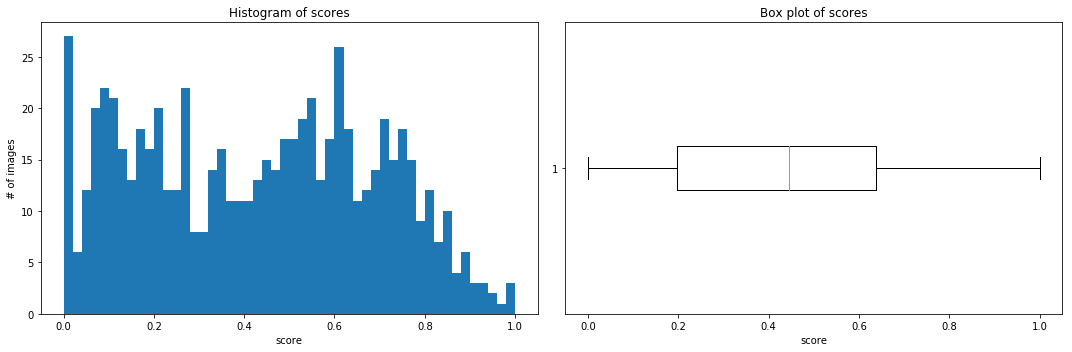

In [62]:
f, axarr = plt.subplots(1,2,figsize=(15,5))
axarr[0].hist(scores.score, bins=50)
axarr[0].set_title('Histogram of scores')
axarr[0].set_xlabel('score')
axarr[0].set_ylabel('# of images')
axarr[1].boxplot(scores.score, 0, 'rs', 0)
axarr[1].set_title('Box plot of scores')
axarr[1].set_xlabel('score')
f.tight_layout()